# Descripción del proyecto

## Inicialización
En la primera parte de este trabajo se llevarán a cabo los siguientes procesos:
1. Cargar las librerías necesarias para el análisis.
2. Importar el conjunto de datos.
3. Revisar los datos para proceder a su limpieza y enriquecimiento, en caso de ser necesario.

In [97]:
#Importar librerías 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import norm 
import datetime as dt
import plotly.graph_objects as go
import math


In [ ]:
#Cargar datos
registros = pd.read_csv("/datasets/logs_exp_us.csv", sep="\t")

In [41]:
print(registros.head())

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248


In [42]:
print(registros.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


In [43]:
print(registros.duplicated().sum())

413


In [44]:
print(registros[registros.duplicated()])

                      EventName         DeviceIDHash  EventTimestamp  ExpId
453            MainScreenAppear  5613408041324010552      1564474784    248
2350           CartScreenAppear  1694940645335807244      1564609899    248
3573           MainScreenAppear   434103746454591587      1564628377    248
4076           MainScreenAppear  3761373764179762633      1564631266    247
4803           MainScreenAppear  2835328739789306622      1564634641    248
...                         ...                  ...             ...    ...
242329         MainScreenAppear  8870358373313968633      1565206004    247
242332  PaymentScreenSuccessful  4718002964983105693      1565206005    247
242360  PaymentScreenSuccessful  2382591782303281935      1565206049    246
242362         CartScreenAppear  2382591782303281935      1565206049    246
242635         MainScreenAppear  4097782667445790512      1565206618    246

[413 rows x 4 columns]


### Conclusiones
Los datos se cargaron en el DataFrame "registros", que contiene información sobre el evento, el ID del usuario, la fecha y el ID del experimento, distribuidos en 4 columnas y 244,126 filas. Posteriormente, se aplicaron métodos de la librería pandas para verificar la calidad de los datos: se confirmó que no hay valores nulos, pero se detectaron filas duplicadas que deben eliminarse para evitar sesgos en los resultados. Además, es necesario ajustar los nombres de las columnas al formato estándar y convertir el tipo de dato de la columna "EventTimestamp" a formato de fecha (datetime).

## Preprocesamiento de datos 
En la presente etapa se realizarán los cambios necesarios para el posterior análisis. Estos fueron identificados en el proceso de Inicialización.

In [45]:
#Modificar nombres de columnas
registros.columns = ['evento', 'id_usuario', 'datetime', 'id_exp']

In [46]:
#Modificar tipo de dato columna 'date'
registros['datetime'] = pd.to_datetime(registros['datetime'] , unit='s')

print(registros['datetime'])

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
244121   2019-08-07 21:12:25
244122   2019-08-07 21:13:59
244123   2019-08-07 21:14:43
244124   2019-08-07 21:14:58
244125   2019-08-07 21:15:17
Name: datetime, Length: 244126, dtype: datetime64[ns]


In [47]:
#Crear columnas de fecha y hora
registros['fecha'] = registros['datetime'].dt.date
registros['hora'] = registros['datetime'].dt.time

In [48]:
#Transformar columas nueva a formato datetime

registros['fecha'] = pd.to_datetime(registros['fecha'])
registros['hora'] = pd.to_datetime(registros['hora'], format='%H:%M:%S')

In [49]:
#Eliminar filas de duplicados exactos

registros.drop_duplicates(inplace=True)

### Conclusiones 

Durante el proceso de preprocesamiento, se renombraron las columnas al formato snake case para mayor consistencia, asignando además un nombre más descriptivo al identificador de usuario. También se convirtió el tipo de dato de la columna datetime al formato de fecha y hora adecuado. Adicionalmente, se crearon columnas nuevas que separan la información temporal: una contiene solo la fecha y otra únicamente la hora de cada registro.

## Análisis de datos

### Estudiar y comprobar datos

In [50]:
 #Calcular cantidad de eventos en los registros 

eventos = registros.groupby('evento')['id_usuario'].count()
print(eventos)

evento
CartScreenAppear            42668
MainScreenAppear           119101
OffersScreenAppear          46808
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: id_usuario, dtype: int64


In [51]:
#Calcular número de eventos por usuario 
usuarios = registros.groupby('id_usuario', as_index=False)['evento'].count()
usuarios.columns = ['usuario', 'num_eventos']
print(usuarios)

                  usuario  num_eventos
0        6888746892508752            1
1        6909561520679493            5
2        6922444491712477           47
3        7435777799948366            6
4        7702139951469979          137
...                   ...          ...
7546  9217594193087726423            9
7547  9219463515465815368           17
7548  9220879493065341500            7
7549  9221926045299980007            7
7550  9222603179720523844           59

[7551 rows x 2 columns]


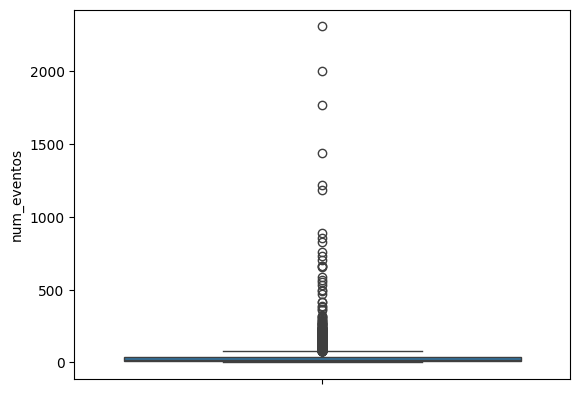

In [52]:
#Ver distribución de 'usuarios'

sns.boxplot(usuarios['num_eventos'])

plt.show()


In [53]:
#Calcular eventos promedio por usuario
print('Media,', usuarios['num_eventos'].mean().round(2))

#Calcular mediana
print('Mediana:', usuarios['num_eventos'].median())

#Calcular moda
print('Moda:', usuarios['num_eventos'].mode())


Media, 32.28
Mediana: 20.0
Moda: 0    5
Name: num_eventos, dtype: int64


In [ ]:
#Calcular límite superior outliers
q1 = usuarios['num_eventos'].quantile(0.25)
q3 = usuarios['num_eventos'].quantile(0.75)

iqr = q3 - q1

outliers_sup = q3 + 1.5 * iqr

print(f'El límite superior de outliers es: {outliers_sup}')

El límite superior de outliers es: 79.0


In [ ]:
#Calcular cantidad de usuarios con num_eventos igual o mayor a 79
usuarios_outliers = usuarios.query("num_eventos >= 79").shape[0]

print(f'La cantidad de usuarios anómalos es: {usuarios_outliers}')

La cantidad de usuarios anómalos es: 508


In [116]:
#Calcular porcentaje usuarios anómalos 
total_usuario = usuarios.shape[0]

p_usuario_anomalos = usuarios_outliers / total_usuario * 100

print(f'El porcentaje de usuario anómales es del: {p_usuario_anomalos:.2f}%')

El porcentaje de usuario anómales es del: 6.73%


In [54]:
#Encontrar registro más antiguo y más actual 
print('Primer registro:', registros['fecha'].min())

print('Último registro:', registros['fecha'].max())

Primer registro: 2019-07-25 00:00:00
Último registro: 2019-08-07 00:00:00


In [55]:
#Graficar cantidad de eventos por fecha y hora

#plt.figure(figsize=[9,5])

#registros.plot(kind='bar',
                #x='datetime',
                #y='evento',
                #xlabel='Fecha y hora del evento',
                #ylabel='Número de eventos',
                #title='Cantidad de ventos registrados por fecha y hora',
                #rot=30,
#)

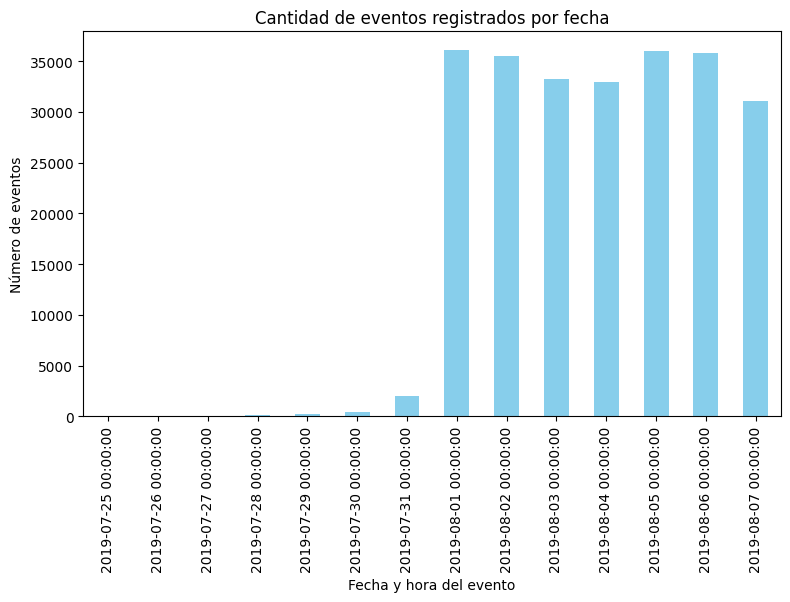

In [56]:
#Graficar cantidad de eventos por fecha y hora 

    #agrupar por datetime y contar el número de eventos
eventos_por_fecha_hora = registros.groupby('fecha').size()


eventos_por_fecha_hora.plot(kind='bar', figsize=(9, 5), color='skyblue')

plt.xlabel('Fecha y hora del evento')
plt.ylabel('Número de eventos')
plt.title('Cantidad de eventos registrados por fecha')
plt.xticks(rotation=90)

plt.show()

In [57]:
#Encontrar momento en que los datos están completos

    #redactar filtro
#filtro_datos_completos = registros[]
#registros.groupby(['id_usuario', 'datetime'], as_index=False)['evento'].count()

In [58]:
#Filtrar df registros por fecha donde hay gran cantidad de datos 

registros_filtrado = registros[registros['fecha'] >= '2019-08-01']

In [ ]:
#Calcular cantidad de registros eliminados 

print(((registros.shape[0] - registros_filtrado.shape[0]) / registros.shape[0] * 100))

1.159560630741897


In [87]:
#Revisar existencia de usuarios por grupo experimental

usuarios_por_grupo = registros_filtrado.groupby('id_exp')['id_usuario'].nunique()
print(usuarios_por_grupo)

id_exp
246    2484
247    2513
248    2537
Name: id_usuario, dtype: int64


#### Conclusiones 
Al analizar los datos, observamos que 7,551 usuarios únicos han interactuado con la plataforma de ventas. La mayoría de ellos tiene 5 eventos asociados, lo que sugiere que suelen visitar la página entre una y dos veces aproximadamente. Sin embargo, 508 usuarios (6.7%) han participado en 79 eventos o más, lo que indica un nivel de actividad significativamente mayor.

Al examinar las fechas de los registros, se evidencia que la cantidad de datos recolectados antes del 1 de agosto es menor, lo que podría generar un sesgo en los análisis posteriores debido a la incompletitud de la información en ese periodo. Por este motivo, se decide excluir los datos registrados hasta el 31 de julio, garantizando así una base de datos más homogénea y representativa para el estudio.

### Estudiar el embudo de eventos

In [68]:
#Calcular frecuencia de eventos y usuarios

#eventos = registros_filtrado.groupby('evento', as_index=False).agg({'evento': 'count', 'id_usuario': pd.Series.nunique})
eventos = (registros_filtrado.groupby('evento').agg({'datetime': 'count', 'id_usuario': pd.Series.nunique})
                             .reset_index()
                             .sort_values(by='id_usuario', ascending=False)
)
eventos.columns = ['evento', 'num_ocurrencias', 'num_usuarios']
eventos['%_usuarios'] = eventos['num_usuarios'] / eventos['num_ocurrencias'] * 100

print(eventos.sort_values(by='num_ocurrencias', ascending=False))

                    evento  num_ocurrencias  num_usuarios  %_usuarios
1         MainScreenAppear           117328          7419    6.323299
2       OffersScreenAppear            46333          4593    9.913021
0         CartScreenAppear            42303          3734    8.826797
3  PaymentScreenSuccessful            33918          3539   10.433988
4                 Tutorial             1005           840   83.582090


In [82]:
#Graficar embudo para 'eventos' sin considerar el evento Tutorial   

eventos_no_tutorial = eventos.query('evento != "Tutorial"')

fig = go.Figure(go.Funnel(
    y=eventos_no_tutorial['evento'],
    x=eventos_no_tutorial['num_usuarios']
))

# Mostrar el gráfico
fig.show()

#### Conclusiones 
Se analiza el comportamiento de los usuarios a lo largo de su recorrido en la plataforma, con el objetivo de comprender cómo llegan al evento de mayor interés: 'PaymentScreenSuccessful'. Para ello, se utiliza una gráfica de embudo que muestra la cantidad de usuarios por evento, asumiendo que existe un orden lógico que la mayoría sigue hasta concretar el pago.

El embudo comienza con 7,419 usuarios únicos y revela que la mayor pérdida ocurre en la etapa 'OffersScreenAppear', donde el número de usuarios disminuye en aproximadamente un 40%. Este fenómeno podría deberse a que la página no es suficientemente intuitiva (user-friendly) o a que los precios de los productos son más altos en comparación con otras plataformas.

Para entender mejor este descenso en la etapa de ofertas, sería necesario contar con más información sobre el diseño y la experiencia del usuario en el sitio web.

Excluyendo a los usuarios que visitan el tutorial —una etapa opcional que puede completarse en cualquier momento—, el 47.7% de los visitantes iniciales realizan una compra, lo que equivale a casi el 98% de quienes ingresan al carrito de compras. Esto sugiere que la etapa 'CartScreenAppear' es un punto clave en el proceso, funcionando como el momento decisivo ("ajá") que impulsa a los usuarios a concretar sus compras en el sitio web.

### Estudiar los resultados del experimento

In [89]:
# Mostrar usuarios por experimento 
print(usuarios_por_grupo)

id_exp
246    2484
247    2513
248    2537
Name: id_usuario, dtype: int64


In [75]:
#Calcular usuarios por grupo y evento

usuario_evento_por_grupo = registros_filtrado.pivot_table(index='evento',
                                                           columns='id_exp',
                                                           values='id_usuario',
                                                           aggfunc='nunique'
)

print(usuario_evento_por_grupo)

id_exp                    246   247   248
evento                                   
CartScreenAppear         1266  1238  1230
MainScreenAppear         2450  2476  2493
OffersScreenAppear       1542  1520  1531
PaymentScreenSuccessful  1200  1158  1181
Tutorial                  278   283   279


In [95]:
#Crear función para calcular diferencias significativas entre pruebas 

def comparacion_pruebas (exitos1, exitos2, usuarios1, usuarios2, alpha=0.01):

    #proporción éxitos exp1
    p1 = exitos1 / usuarios1

    #proporción de éxitos exp2
    p2 = exitos2 / usuarios2

    #proporción combinada
    p_combinada = (exitos1 + exitos2) / (usuarios1 + usuarios2)

    #diferencia proporciones entre pruebas
    dif_p = p1 - p2

    #calcular valor z 
    valor_z = dif_p / math.sqrt(p_combinada * (1 - p_combinada) * ((1 / usuarios1) +(1 / usuarios2)))

    #calcular valor p 
    valor_p = 2 * (1 - norm.cdf(abs(valor_z)))



    print('Valor p:', valor_p)

    if valor_p < alpha:
        print('Se rechaza la hipótesis nula. Hay una diferencia estadística significativa entre ambas pruebas')
    else: 
        print('No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa')

In [99]:
#Crear función para automatizar el estudio estadístico de eventos de cada experimento

def comp_evento_por_hipotesis(usuario_evento_por_grupo, usuarios_por_grupo, evento, exp1, exp2):
    proporcion_1 = usuario_evento_por_grupo.loc[evento, exp1] / usuarios_por_grupo.loc[exp1]
    proporcion_2 = usuario_evento_por_grupo.loc[evento, exp2] / usuarios_por_grupo.loc[exp2]

    print(f'Proporción de {evento} en {exp1} es de: {proporcion_1}')
    print(f'Proporción de {evento} en {exp2} es de: {proporcion_2}')

    comparacion_pruebas(usuario_evento_por_grupo.loc[evento, exp1], 
                        usuario_evento_por_grupo.loc[evento, exp2],
                        usuarios_por_grupo.loc[exp1],
                        usuarios_por_grupo.loc[exp2]
                        )

#### Comparar eventos en experimentos 246 y 247


In [100]:
for evento in usuario_evento_por_grupo.index:
    comp_evento_por_hipotesis(usuario_evento_por_grupo,
                              usuarios_por_grupo,
                              evento, 246, 247)
    print()

Proporción de CartScreenAppear en 246 es de: 0.5096618357487923
Proporción de CartScreenAppear en 247 es de: 0.4926382809391166
Valor p: 0.22883372237997213
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de MainScreenAppear en 246 es de: 0.9863123993558777
Proporción de MainScreenAppear en 247 es de: 0.9852765618782332
Valor p: 0.7570597232046099
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de OffersScreenAppear en 246 es de: 0.6207729468599034
Proporción de OffersScreenAppear en 247 es de: 0.6048547552725826
Valor p: 0.2480954578522181
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de PaymentScreenSuccessful en 246 es de: 0.4830917874396135
Proporción de PaymentScreenSuccessful en 247 es de: 0.46080382013529647
Valor p: 0.11456679313141849
No se rechaza la hipótesis nula: no hay evidencia suficiente de una difer

#### Comparar eventos en experimentos 246 y 248

In [101]:
for evento in usuario_evento_por_grupo.index:
    comp_evento_por_hipotesis(usuario_evento_por_grupo,
                              usuarios_por_grupo,
                              evento, 246, 248)
    print()

Proporción de CartScreenAppear en 246 es de: 0.5096618357487923
Proporción de CartScreenAppear en 248 es de: 0.48482459597950334
Valor p: 0.07842923237520116
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de MainScreenAppear en 246 es de: 0.9863123993558777
Proporción de MainScreenAppear en 248 es de: 0.9826566811194324
Valor p: 0.2949721933554552
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de OffersScreenAppear en 246 es de: 0.6207729468599034
Proporción de OffersScreenAppear en 248 es de: 0.6034686637761135
Valor p: 0.20836205402738917
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de PaymentScreenSuccessful en 246 es de: 0.4830917874396135
Proporción de PaymentScreenSuccessful en 248 es de: 0.46551044540796216
Valor p: 0.2122553275697796
No se rechaza la hipótesis nula: no hay evidencia suficiente de una dife

#### Comparar eventos en experimentos 247 y 248

In [102]:
for evento in usuario_evento_por_grupo.index:
    comp_evento_por_hipotesis(usuario_evento_por_grupo,
                              usuarios_por_grupo,
                              evento, 247, 248)
    print()

Proporción de CartScreenAppear en 247 es de: 0.4926382809391166
Proporción de CartScreenAppear en 248 es de: 0.48482459597950334
Valor p: 0.5786197879539783
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de MainScreenAppear en 247 es de: 0.9852765618782332
Proporción de MainScreenAppear en 248 es de: 0.9826566811194324
Valor p: 0.4587053616621515
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de OffersScreenAppear en 247 es de: 0.6048547552725826
Proporción de OffersScreenAppear en 248 es de: 0.6034686637761135
Valor p: 0.9197817830592261
No se rechaza la hipótesis nula: no hay evidencia suficiente de una diferencia significativa

Proporción de PaymentScreenSuccessful en 247 es de: 0.46080382013529647
Proporción de PaymentScreenSuccessful en 248 es de: 0.46551044540796216
Valor p: 0.7373415053803964
No se rechaza la hipótesis nula: no hay evidencia suficiente de una difer

#### 3.3.1 Conclusiones 

Tras realizar un análisis estadístico de las muestras de cada experimento, podemos concluir que los grupos de control (246 y 247) cumplen con su objetivo. Los resultados de la comparación entre ambos experimentos por evento muestran que no existen factores externos significativos que puedan influir en los resultados después de aplicar los cambios al grupo 248.

Por otro lado, se evalúa la diferencia estadística entre cada grupo de control y el grupo 248, que fue expuesto a los cambios en la plataforma, para cada uno de los eventos. Los análisis revelan que la prueba B no ha tenido el impacto esperado, ya que los resultados demuestran que las proporciones de usuarios en cada uno de los eventos a lo largo de los tres experimentos no presentan variaciones significativas.

## Conclusiones generales


Se recomienda no implementar los cambios propuestos en el experimento 248, ya que los resultados de los experimentos de control indican que el impacto es insignificante en cualquiera de los 5 eventos. Por lo tanto, aplicar estos cambios en la página web representaría una inversión innecesaria.

Por otro lado, se sugiere investigar los factores que afectan el desplazamiento de usuarios desde MainScreenAppears hasta OffersScreenAppear, ya que el 77% de los visitantes que participan en el evento de ofertas logran concretar una compra. Sería beneficioso identificar y abordar estos factores para aumentar la cantidad de usuarios que continúan navegando una vez en la página principal.